## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# External imports
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
# Internal imports
import utils
import okcupidio
import linearRegression
import kmeans
import pca
import gaussianModel
import RBFkernel
import sgd
import linearRBF
from linearBinaryClassifier import LinearBinaryClassifier
from linearRandom import LinearRandom
from randomMap import RandomMap
from genericLinear import LinearSGD

## Generate Features from OK Cupid Data

In [7]:
# SETTINGS
savename = 'features.p'

In [8]:
# MAKE FEATURES
# Loads data (fairly raw)
data = okcupidio.loadData()
# Preprocess data
okcupidio.processData(data)
# And make binary features out of it
features, featureNames = okcupidio.buildFeatures(data)
# First, replace -1 with nans
features[features == -1] = np.nan
# Save
pickle.dump((features, featureNames), open(savename, 'w'), 2)

orientation multiple choice
sign multiple choice
height int
body_type multiple choice
education multiple choice
ethnicity list
drinks ranked
wants_more_kids multiple choice
likes_cats int
likes_dogs int
has_cats int
religion multiple choice
income int
speaks list
has_kids int
religion_importance ranked
status multiple choice
drugs ranked
last_online date
diet multiple choice
job multiple choice
sex multiple choice
sign_matters multiple choice
age int
smokes multiple choice
has_dogs int
essay9 short response
essay8 short response
essay1 short response
essay0 short response
essay3 short response
essay2 short response
essay5 short response
essay4 short response
essay7 short response
essay6 short response


## Make feature arrays using imputation

In [19]:
# LOAD FEATURES
features, featureNames = pickle.load(open(savename, 'r'))

In [28]:
# Settings
labelsColumn = 'sex_m'
dropData = ['last_online']
minResponseRate = 0.90
nTest = 10000

In [29]:
# Load data
rawDF = pd.DataFrame(data=features, columns=featureNames)

# drop unwanted data
for drop in dropData:
    
    rawDF.drop(drop, 1, inplace=True)
    
# Ignore data with response rates too low
# columns = df.columns[df.columns != labelsColumn]
columns = rawDF.columns
for col in columns:
    
    if rawDF[col].notnull().mean() < minResponseRate:
        
        rawDF.drop(col, 1, inplace=True)

In [30]:
# IMPUTATION
# (replace missing data, except for in the labelsColumn)
imputedDF = rawDF.copy()
columns = imputedDF.columns[imputedDF.columns != labelsColumn]
for col in columns:
    series = imputedDF[col]
    nChoice = series.isnull().sum()
    if nChoice > 0:
        notnulls = series[series.notnull()]
#         vals = np.random.choice(notnulls, nChoice)
        vals = notnulls.mean() * np.ones(nChoice)
        series[series.isnull()] = vals
        imputedDF[col] = series

In [31]:
# Now remove people without reported values in the labels Column
df = imputedDF[imputedDF[labelsColumn].notnull()]
# Ignore entries where stddev == 0
columns = df.columns[df.columns != labelsColumn]
for col in columns:
    if df[col].std() == 0:
        df.drop(col, 1, inplace=True)

In [32]:
# Get arrays from the data frame
dfShort = df.drop(labelsColumn, 1)
x = dfShort.values
names = df.columns.tolist()
y = df[labelsColumn].values
# And save
pickle.dump((x, y, names), open('dataset.p', 'w'), 2)

In [33]:
# NOW SPLIT the dataset
y = y.reshape([len(y), 1])
nTrain = len(x) - nTest
np.random.seed(0)
ind = np.random.rand(len(x)).argsort()
trainInd = ind[0:nTrain]
testInd = ind[nTrain:]
xtrain, ytrain = (x[trainInd], y[trainInd])
xtest, ytest = (x[testInd], y[testInd])
# And condition it
xtrain, center, scale = utils.condition(xtrain)
xtest, center, scale = utils.condition(xtest, center, scale)

# save the split set
pickle.dump((xtrain, ytrain), open('data_train.p', 'w'), 2)
pickle.dump((xtest, ytest), open('data_test.p','w'), 2)

## Load Data

In [3]:
# load data if necessary:
x, y, names = pickle.load(open('dataset.p'))
xtrain, ytrain = pickle.load(open('data_train.p', 'r'))
xtest, ytest = pickle.load(open('data_test.p', 'r'))

## Linear regression

### Un-boosted

In [46]:
lr = linearRegression.BinaryLinearRegression(regScale=1e1)
lr.fit(xtrain, ytrain)
ypred = lr.pred(xtrain)
wrong = (ypred != ytrain).astype(float)
print "0/1 loss:", wrong.mean()
print "mean confidence:", lr.confidence(xtrain).mean()

0/1 loss: 0.124294237777
mean confidence: 0.821598013513


### L2 boost

In [178]:
def evalPredictors(predictors, x, nu=0.5):
    out = predictors[0](x)
    for predictor in predictors[1:]:
        out += nu*predictor(x)
    return out

In [176]:
def f0(x):
    return ymean * np.ones([len(x), 1])
predictors = [f0]
evalPredictors(predictors, xtrain)

array([[ 0.59734513],
       [ 0.59734513],
       [ 0.59734513],
       ..., 
       [ 0.59734513],
       [ 0.59734513],
       [ 0.59734513]])

In [214]:
lr = linearRegression.BinaryLinearRegression(regScale=1e0, classify=False, scalarOffset=True)
lr.fit(xtrain, ytrain)
ypredBase = lr.ypred(xtrain)

In [226]:
# dataWeights = np.ones([len(xtrain), 1])

ymean = ytrain.mean()
nu = 1
predictors = [lambda x : np.zeros([len(x), 1])]

for i in range(10):
    ypred = evalPredictors(predictors, xtrain, nu)
    residuals = ytrain - ypred
    print (residuals**2).mean()
    lr = linearRegression.BinaryLinearRegression(regScale=1e0, classify=False, scalarOffset=True)
    lr.fit(xtrain, residuals) 
    predictors.append(lr.ypred)

0.597345132743
0.115838473037
0.115838472996
0.115838472996
0.115838472996
0.115838472996
0.115838472996
0.115838472996
0.115838472996
0.115838472996


In [216]:
abs(ypred - ypredBase).mean()

0.070958636734254038

### AdaBoost

In [99]:
classifierWeights = []
classifiers = []
dataWeights = np.ones([len(xtrain), 1])/len(xtrain)

for i in range(6):
    lr = linearRegression.BinaryLinearRegression(regScale=1e1)
    lr.fit(xtrain, ytrain, dataWeights=dataWeights)
    ypred = lr.pred(xtrain)
    wrong = (ypred != ytrain).astype(float)
    error = (dataWeights * wrong).sum()/dataWeights.sum()
    alpha = np.log((1-error)/error)
    classifierWeights.append(alpha)
    dataWeights = dataWeights*np.exp(alpha * wrong)
    classifiers.append(lr)
    print "0/1 loss:", wrong.mean()
    print "mean confidence:", lr.confidence(xtrain).mean()
    print "weighted prediction error:", error
    print "classifier weight:", alpha
    
def weightedClassify(classifiers, weights, x):
    """
    Assumes the predictors (classifiers[i].pred()) return values of 0/1
    """
    preds = [(2*classifier.pred(x)-1) for classifier in classifiers]
    pred = np.zeros(preds[0].shape)
    for i in range(len(classifiers)):
        pred += weights[i] * preds[i]
    return 0.5 * (np.sign(pred) + 1)
    

0/1 loss: 0.143294758339
mean confidence: 0.800113344102
weighted prediction error: 0.143294758339
classifier weight: 1.78819016145
0/1 loss: 0.270011612542
mean confidence: 0.665390346587
weighted prediction error: 0.347707796013
classifier weight: 0.629130166726
0/1 loss: 0.216954310656
mean confidence: 0.710370099561
weighted prediction error: 0.424040300001
classifier weight: 0.306209195083
0/1 loss: 0.187142113483
mean confidence: 0.735534884943
weighted prediction error: 0.454624774928
classifier weight: 0.182001635901
0/1 loss: 0.18491971329
mean confidence: 0.736882804124
weighted prediction error: 0.460938217946
classifier weight: 0.156566171272
0/1 loss: 0.226444560125
mean confidence: 0.683255291658
weighted prediction error: 0.506085715952
classifier weight: -0.0243440659973


In [100]:
ypred = weightedClassify(classifiers, classifierWeights, xtrain)
print (ypred != ytrain).mean()

0.143294758339


#### Most male traits

In [227]:
ind = (-lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i, names[j], lr.w[j,0]

0 age 1.55040290924e-13
1 smokes_no 9.93194957197e-14
2 smokes_trying to quit 9.01641580437e-14
3 body_type_average 7.94789918242e-14
4 smokes_when drinking 7.79452158287e-14
5 body_type_fit 7.57853276601e-14
6 body_type_athletic 7.38548692681e-14
7 smokes_sometimes 6.43060705591e-14
8 body_type_thin 5.04457787376e-14
9 body_type_curvy 4.66617725772e-14


#### Most female traits

In [228]:
ind = (lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i, names[j], lr.w[j,0]

0 orientation_straight -1.28978185952e-13
1 orientation_gay -1.08215455754e-13
2 orientation_bisexual -7.81802785141e-14
3 speaks_spanish -3.88851942511e-15
4 speaks_french -2.65929380093e-15
5 speaks_chinese -2.18074597132e-15
6 speaks_german -1.67629713279e-15
7 speaks_c++ -1.56260462272e-15
8 speaks_italian -1.43012026339e-15
9 speaks_japanese -1.30275990614e-15


## K-means

In [229]:
# Perform PCA
nKeepKmeans = 25
w, vkmeans = pca.PCA(xtrain)
xa = pca.proj(xtrain, vkmeans, nKeepKmeans)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vkmeans, nKeepKmeans)

Sum of eigenvalues (direct): 117
Sum of eigenvalues (from xTx): 117


In [230]:
classifierWeights = []
classifiers = []
dataWeights = np.ones([len(xtrain), 1])/len(xtrain)
centroids = None

for i in range(1):
    km = kmeans.kmeans(xa, nCluster=256, xtol=0.01)
    km.fit(centroids=centroids, dataWeights=dataWeights)
    km.labelClusters(ytrain)
#     centroids = km.centroids.copy()
    ypred = km.pred(xa)
    wrong = (ypred != ytrain).astype(float)
    error = (dataWeights * wrong).sum()/dataWeights.sum()
    alpha = np.log((1-error)/error)
    classifierWeights.append(alpha)
    dataWeights = dataWeights*np.exp(alpha * wrong)
    dataWeights /= dataWeights.sum()
    classifiers.append(km)
    print "0/1 loss:", wrong.mean()
    print "weighted prediction error:", error
    print "classifier weight:", alpha

(max centroid change, error):  13.4175514076 13.4502553437
(max centroid change, error):  9.93206821351 10.403992644
(max centroid change, error):  16.5874647422 8.9666032007
(max centroid change, error):  11.6622061043 8.62256416116
(max centroid change, error):  2.05437987043 8.4941313216
(max centroid change, error):  6.95329505072 8.3809897136
(max centroid change, error):  0.872334910023 8.35633276377
(max centroid change, error):  0.290971914912 8.33898788237
(max centroid change, error):  0.463138586155 8.32472698157


KeyboardInterrupt: 

In [57]:
def weightedClassify(classifiers, weights, x):
    """
    Assumes the predictors (classifiers[i].pred()) return values of 0/1
    """
    preds = [(2*classifier.pred(x)-1) for classifier in classifiers]
    pred = np.zeros(preds[0].shape)
    for i in range(len(classifiers)):
        pred += weights[i] * preds[i]
    return 0.5 * (np.sign(pred) + 1)

In [58]:
ypred = weightedClassify(classifiers, classifierWeights, xa)
print (ypred != ytrain).mean()

0.3288751852


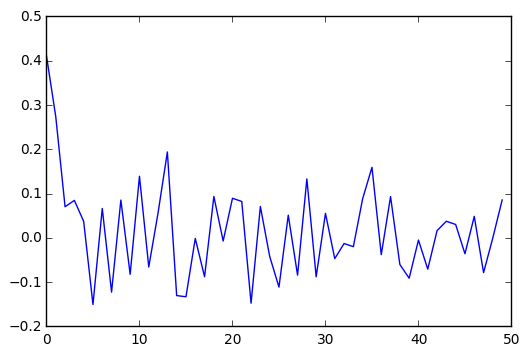

In [59]:
plt.plot(classifierWeights)

In [21]:
km = kmeans.kmeans(xa, nCluster=256)
km.fit()
km.labelClusters(ytrain)
(km.pred(xa) != ytrain).mean()

(max centroid change, error):  16.0089042892 15.8523518093
(max centroid change, error):  5.02248226342 14.5590176649
(max centroid change, error):  20.0202672069 13.2009716095
(max centroid change, error):  4.78612748241 12.8749654235
(max centroid change, error):  2.3385363831 12.6951276406
(max centroid change, error):  2.59806544382 12.6091561306
(max centroid change, error):  0.603887261529 12.5630614835
(max centroid change, error):  1.24535688062 12.5289500449
(max centroid change, error):  0.450835507793 12.5056491165
(max centroid change, error):  0.252260029017 12.4850137476
(max centroid change, error):  0.409840292294 12.4647265202
(max centroid change, error):  0.496539399378 12.4442323439
(max centroid change, error):  0.419067645178 12.4283941856
(max centroid change, error):  0.658761612335 12.41125564
(max centroid change, error):  1.41022616424 12.3920603748
(max centroid change, error):  1.78648913691 12.3691487059
(max centroid change, error):  0.754162921118 12.340

0.29281624154086411

In [24]:
km.fit(centroids=km.centroids.copy())

(max centroid change, error):  0.0 12.2654711186
(max centroid change, error):  0.0 12.2654711186
Final error:  12.2654711186


In [22]:
(km.pred(xatest) != ytest).mean()

0.31630000000000003

## Gaussian Model

In [49]:
# Perform PCA
nKeepGauss = 20
w, vgaussian = pca.PCA(xtrain)
xa = pca.proj(xtrain, vgaussian, nKeepGauss)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vgaussian, nKeepGauss)

Sum of eigenvalues (direct): 117
Sum of eigenvalues (from xTx): 117


In [50]:
# "train" the model
gm = gaussianModel.GaussianModel()
gm.fit(xa, ytrain)
(gm.pred(xa) != ytrain).mean()

0.38033075721779525

## RBFKernel square loss

In [205]:
linearRBFSavename = 'linearRBF.p'

In [123]:
# Condition and perform PCA
#xa, center, scale = utils.condition(xtrain)
w, v = pca.PCA(xtrain)
xa = pca.proj(xtrain, v, 40)
xatest = pca.proj(xtest, v, 20)

Sum of eigenvalues (direct): 214
Sum of eigenvalues (from xTx): 214


In [215]:
# Initialize
lr = linearRBF.LinearRBF(xa, ytrain, miniBatchSize=30, learningRateScale=1e-6)

In [216]:
try:
    %time lr.fit(subset=3000, maxIter=4)
finally:
    pickle.dump(lr, open(linearRBFSavename, 'w'), 2)

training loss: 0.603333333333
training 0/1 loss: 0.603333333333

Step:  1
training loss: 0.377093531142
training 0/1 loss: 0.531

Step:  2
training loss: 0.349516691918
training 0/1 loss: 0.509666666667

Step:  3
training loss: 0.327868480804
training 0/1 loss: 0.486666666667

Step:  4
training loss: 0.309795957291
training 0/1 loss: 0.463333333333

CPU times: user 2min 1s, sys: 1min 59s, total: 4min 1s
Wall time: 1min 52s


## Logstic regression

In [45]:
# dataWeights = np.ones([len(xtrain), 1])
# dataWeights = np.random.rand(len(xtrain), 1)
dataWeights = None
# dataWeights /= dataWeights.sum()
# print dataWeights.mean()
logistic = LinearSGD(xtrain, ytrain, learningRateScale=1e-1, lossScheme='softmax', miniBatchSize=100, tau0=int(1e5), kappa=0.55)
logistic.fit(maxIter=30, ftol=1e-6, dataWeights=dataWeights)


training loss: 1.38779317775e-05
training 0/1 loss: 0.597345132743

Step:  1
training loss: 6.16824429737e-06
training 0/1 loss: 0.125315340568

Step:  2
training loss: 6.13046738129e-06
training 0/1 loss: 0.125235254074

Step:  3
training loss: 6.10834673522e-06
training 0/1 loss: 0.124174108037

Step:  4
training loss: 6.11229998318e-06
training 0/1 loss: 0.124574540504

Step:  5
training loss: 6.10612821976e-06
training 0/1 loss: 0.124694670244

Step:  6
training loss: 6.09972541109e-06
training 0/1 loss: 0.124754735114

Step:  7
training loss: 6.10038885491e-06
training 0/1 loss: 0.12425419453

Step:  8
training loss: 6.1005169914e-06
training 0/1 loss: 0.124894886477

Step:  9
training loss: 6.09864451434e-06
training 0/1 loss: 0.124634605374

Step:  10
training loss: 6.09372884228e-06
training 0/1 loss: 0.124274216153

Step:  11
training loss: 6.09360727033e-06
training 0/1 loss: 0.12437432427

Step:  12
training loss: 6.09164575179e-06
training 0/1 loss: 0.124714691867

Step:  1

## RBF Kernel softmax

In [163]:
lr2 = linearRBF.LinearRBF(xa, ytrain, miniBatchSize=30, learningRateScale=1e-3, lossScheme='softmax', kappa=0.55, tau0=int(1e6))

In [164]:
lr2.fit(subset=3000, maxIter=1)

training loss: 0.69314718056
training 0/1 loss: 0.603333333333

Step:  1
training loss: 0.647908916075
training 0/1 loss: 0.218666666667



## Linear Random Map

In [40]:
lrm = LinearRandom(xtrain, ytrain, lossScheme='softmax', learningRateScale=5e-4, regScale=0., miniBatchSize=50, \
                  tau0=int(1e5), kappa=0.55, nRandFeatures=1000)
lrm.fit(maxIter=30)

training loss: 0.69314718056
training 0/1 loss: 0.597345132743

Step:  1
training loss: 0.654918779348
training 0/1 loss: 0.250410443279

Step:  2
training loss: 0.636551462115
training 0/1 loss: 0.243242702118

Step:  3
training loss: 0.623937748346
training 0/1 loss: 0.236215112321

Step:  4
training loss: 0.615000303074
training 0/1 loss: 0.236675609658

Step:  5
training loss: 0.607579802333
training 0/1 loss: 0.234072798623

Step:  6
training loss: 0.601390986119
training 0/1 loss: 0.231149641613

Step:  7
training loss: 0.597032598408
training 0/1 loss: 0.229147479278

Step:  8
training loss: 0.592086720585
training 0/1 loss: 0.228907219797

Step:  9
training loss: 0.58842190926
training 0/1 loss: 0.227685900773

Step:  10
training loss: 0.584993771829
training 0/1 loss: 0.227705922396

Step:  11
training loss: 0.582089134002
training 0/1 loss: 0.226724862852

Step:  12
training loss: 0.579437680883
training 0/1 loss: 0.226204300645

Step:  13
training loss: 0.577007284401
traini

## Ensemble Predictions

In [54]:
xkm = pca.proj(xtrain, vkmeans, nKeepKmeans)
xgm = pca.proj(xtrain, vgaussian, nKeepGauss)
kmPred = km.pred(xkm)
gmPred = gm.pred(xgm)
linPred = lr.pred(xtrain)
# lrmPred = lrm.pred(xtrain)

# Get scaled confidences (for km and gm, the min confidence will be 1/2)
kmConf = (2 * km.confidence(xkm) - 1)
gmConf = (2 * gm.confidence(xgm) - 1)
linConf = lr.confidence(xtrain)

kmPred = (2 * kmPred - 1) * kmConf
gmPred = (2 * gmPred - 1) * gmConf
linPred = (2 * linPred - 1) * linConf
# lrmPred = (2 * lrmPred - 1)

In [59]:
logPred = 2 * softmaxProb(logistic.featureMap(xtrain), logistic.sgd.w) - 1

### Softmax probability

In [79]:
w = lrm.sgd.w
h = lrm.featureMap(xtrain)
# ypred = np.dot(h, w)
lrmPred = softmaxProb(h, w)[:, 1, None]
lrmPred = 2*lrmPred - 1

In [57]:
def softmaxProb(x, w):
    """
    P[i, j] is the probability of belonging to class j given x[i], w[:, j]
    """
    N, m = w.shape
    k = m + 1
    E = np.exp(np.dot(x, w))
    A = 1./(1 + E.sum(1))
    A = utils.columnVector(A)    
    P = np.dot(A, np.ones([1, k]))    
    P[:, 0:-1] *= E
    
    return P[:, 1, None]

In [60]:
allPred = np.concatenate([kmPred.T, gmPred.T, linPred.T, logPred.T]).T

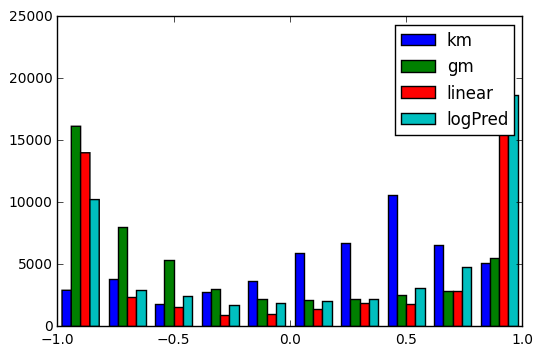

In [61]:
plt.hist(allPred);
plt.legend(['km', 'gm', 'linear', 'logPred'])

In [62]:
def predictor(w):
    predval = (allPred * w).sum(1)
    ypred = np.zeros(ytrain.shape)
    ypred[predval > 0] = 1
    return ypred

def loss(w):
    ypred = predictor(w)
    return (ypred != ytrain).mean()

In [63]:
ws = 2*np.random.rand(5000, 4) - 1
L = [loss(w) for w in ws]

In [64]:
iBest = np.argmin(L)
print L[iBest], ws[iBest]

0.1237136107 [ 0.08730083 -0.04208582  0.9555664   0.20743195]


In [85]:
print loss(np.array([0, 0, 1., 0]))

0.124974972971
